In [1]:
import sys
sys.path.append("../../utils/")
import time
from tqdm.notebook import tqdm
import gc
import glob
import pickle
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,GroupKFold
from sklearn.preprocessing import LabelEncoder

from loss import correl_loss
from trainer import Cite_Trainer

In [3]:
root_path = "../../../input/"
train = np.load("../../data_preprocessing/new_cite_train_final.npz")["arr_0"]
target = pd.read_hdf(f"{root_path}open-problems-multimodal/train_cite_targets.h5").values

print(train.shape,target.shape)

(70988, 735) (70988, 140)


In [4]:
config = dict(
    atte_dims = 128,
    output_num = target.shape[1],
    input_num = train.shape[1],
    dropout = 0.1,
    
    patience = 5,
    max_epochs = 100,
    criterion = correl_loss,
    batch_size = 128,

    n_folds = 3,
    folds_to_train = [0,1,2],
    kfold_random_state = 42,

    tb_dir = "./log/",

    optimizer = torch.optim.AdamW,
    optimizerparams = dict(lr=1e-4, weight_decay=1e-2,amsgrad= True),
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR,

    schedulerparams = dict(milestones=[6,10,15,20,25,30], gamma=0.1,verbose  = True), #9,12,15,20,25,30
    min_epoch = 11,
)


In [5]:
train_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/train_cite_inputs_idxcol.npz",allow_pickle=True)
meta = pd.read_csv(f"{root_path}open-problems-multimodal/metadata.csv",index_col = "cell_id")
meta = meta[meta.technology=="citeseq"]
lbe = LabelEncoder()
meta["cell_type"] = lbe.fit_transform(meta["cell_type"])
meta["gender"] = meta.apply(lambda x:0 if x["donor"]==13176 else 1,axis =1)
meta_train = meta.reindex(train_index["index"])
train_meta = meta_train["gender"].values.reshape(-1, 1)
train = np.concatenate([train,train_meta],axis= -1)
train_meta = meta_train["cell_type"].values.reshape(-1, 1)
train = np.concatenate([train,train_meta],axis= -1)
train.shape

(70988, 737)

In [10]:
class cell(torch.nn.Module):
    def __init__(self,input_dim,out_dim,dropout=0.1):
        super().__init__()
        self.weight_1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim,input_dim),
            # torch.nn.Mish(),
            torch.nn.Softmax(dim= -1),
        )
        self.linear_0 = torch.nn.Sequential(
            torch.nn.Linear(input_dim,input_dim),
            torch.nn.Dropout(dropout),
        ) 
        self.linear_1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim,input_dim),
            torch.nn.Mish(),
            )

        self.bn_1 = torch.nn.LayerNorm((input_dim))
        self.bn_2 = torch.nn.LayerNorm((out_dim))
        self.bn_3 = torch.nn.LayerNorm((out_dim))

        self.linear_2 = torch.nn.Sequential(

            torch.nn.Linear(input_dim,out_dim),
            torch.nn.Dropout(dropout),
            # torch.nn.Mish(),
            torch.nn.Linear(out_dim,out_dim),
            # torch.nn.Dropout(dropout),
            torch.nn.Mish(),
            
        )
        self.linear_3 = torch.nn.Sequential(

            torch.nn.Linear(input_dim,out_dim),
            torch.nn.Dropout(dropout),
            # torch.nn.Mish(),
            torch.nn.Linear(out_dim,out_dim),
            # torch.nn.Dropout(dropout),
            torch.nn.Mish(),
            
        )

    def forward(self,x):
        x_1 = self.linear_1(self.linear_0(x) * self.weight_1(x))
        x = self.bn_1(x_1+x)
        x = self.bn_2(x+self.linear_2(x))
        x = self.bn_3(x+self.linear_3(x))
        return x

In [11]:
class modules(torch.nn.Module):
    def __init__(self,config):
        super().__init__()
        input_num = config["input_num"]
        dropout = config["dropout"]
        self.model = torch.nn.ModuleList()

        in_dim_array = [
            [input_num,input_num,input_num,input_num,input_num],
            [input_num,input_num,input_num,input_num,input_num],
            [input_num,input_num,input_num,input_num,input_num],

        ]
        self.out_dim_array = [
            [input_num,input_num,input_num,input_num,input_num],
            [input_num,input_num,input_num,input_num,input_num],
            [input_num,input_num,input_num,input_num,input_num],
        ]

        for i in range(len(in_dim_array)): # 行
            temp_model = torch.nn.ModuleList()
            for j in range(len(in_dim_array[0])): # 列
                dim_in = in_dim_array[i][j]
                dim_out = self.out_dim_array[i][j]
                temp_model.append(
                    torch.nn.Sequential(
                        cell(dim_in,dim_out,dropout),
                        # cell(dim_in,dim_out,dropout),
                    )
                )
            self.model.append(temp_model)

In [12]:
class MLP(torch.nn.Module):
    def __init__(self,config):
        super().__init__()
        output_num = config["output_num"]
        self.input_num = config["input_num"]
        dropout = config["dropout"]

        self.backbone = torch.nn.Linear(self.input_num ,self.input_num)
        self.embedding_1 = torch.nn.Embedding(2,self.input_num)
        self.embedding_2 = torch.nn.Embedding(7,self.input_num)

        self.model = modules(config)

        tail_input_dim = np.sum(np.array(self.model.out_dim_array)[-2:,-2:])
        self.tail = torch.nn.Sequential(
            torch.nn.Linear(tail_input_dim,self.input_num*4),
            torch.nn.Mish(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(self.input_num*4,self.input_num*2),
            torch.nn.Mish(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(self.input_num*2,output_num),
            torch.nn.Mish(),
        )
        
    def forward(self,xin):
        # backbone
        xin = self.backbone(xin[:,:self.input_num]) + self.embedding_2(xin[:,-1].int())  # + self.embedding_1(xin[:,-2].int())# 

        # neck
        temp_model_list = self.model.model[0]
        res_array = []
        res_list  = []
        temp_out = xin

        for id,i in enumerate(temp_model_list):
            temp_out = i(temp_out+xin)
            res_list.append(temp_out) 

        temp_model_list = self.model.model[1]
        temp_out = xin
        for i in range(len(temp_model_list)):
            temp_out = temp_model_list[i](res_list[i]+temp_out)
            res_list[i] = temp_out
        res_array += res_list[-2:]

        temp_model_list = self.model.model[2]
        temp_out = xin
        for i in range(len(temp_model_list)):
            temp_out = temp_model_list[i](res_list[i]+temp_out)
            res_list[i] = temp_out
        res_array += res_list[-2:]

        # tail
        res_array = torch.concat(res_array,dim = -1)
        res_array = self.tail(res_array)
        return res_array


In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"machine has {torch.cuda.device_count()} cuda devices")
    print(f"model of first cuda device is {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")

trainer = Cite_Trainer(device)
kfold = GroupKFold(n_splits=config["n_folds"]) # , shuffle=True, random_state=config["kfold_random_state"]
FOLDS_LIST = list(kfold.split(range(train.shape[0]),groups= meta_train.donor)) #
print("Training started")
fold_scores = []
for num_fold in config["folds_to_train"]:
    model = MLP(config)
    best_score = trainer.train_one_fold(num_fold,FOLDS_LIST,train,target,model,config)
    fold_scores.append(best_score)
print("\n")
print(f"Final average score is {sum(fold_scores)/len(fold_scores)}")
    

machine has 1 cuda devices
model of first cuda device is NVIDIA GeForce RTX 3070
Training started
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.8841502012638505 val_loss:-0.8843342889215529 corr_score:0.8843487462454138
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.9015916311839941 val_loss:-0.8903181724941608 corr_score:0.890333799086804
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9039108825852666 val_loss:-0.8914886946530686 corr_score:0.8915041936711285
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.905347153090374 val_loss:-0.8923952554919056 corr_score:0.8924120507095916
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.9064489137432912 val_loss:-0.8923101523487839 corr_score:0.8923262968441318
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9072696759760215 val_loss:-0.8919102776910841 corr_score:0.8919265058662259
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9101633510431094 val_loss:-0.8934784722082

  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.8805984828783118 val_loss:-0.8931837690637466 corr_score:0.8931986041336613
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.8978210117505945 val_loss:-0.8951645709098653 corr_score:0.8951843002167932
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9006924007249915 val_loss:-0.894454631399601 corr_score:0.8944680620987242
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.902262895003609 val_loss:-0.8961483569855385 corr_score:0.8961655040961394
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.9034500951352327 val_loss:-0.8967820025504903 corr_score:0.8967980345305595
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9043611443561056 val_loss:-0.8974310692320479 corr_score:0.8974419648440757
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9073032710863196 val_loss:-0.8981394666306

  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.881561199407927 val_loss:-0.8873889966942798 corr_score:0.8874451340713546
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.8983380382597759 val_loss:-0.8924899046448456 corr_score:0.8925389727577819
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9006656826478648 val_loss:-0.8908870302397629 corr_score:0.8909310033672688
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.9021053613792539 val_loss:-0.8933202809300916 corr_score:0.893366536780936
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.9032596767884898 val_loss:-0.8938935378502155 corr_score:0.8939408869768909
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9040553707102831 val_loss:-0.8937460362226114 corr_score:0.893796947497635
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9069059681517916 val_loss:-0.89507144621048

In [14]:
fold_scores

[0.8937548192254969, 0.8986140352705745, 0.8952225290272084]

In [15]:
np.mean(fold_scores)

0.89586379450776

In [16]:
# [0.8938266351348627, 0.8986694061118986, 0.8953973503874049]

In [17]:
class ori_Tester:
    def __init__(self,device,config):
        self.device = device
        self.config = config

    def std(self,x):
        return (x - np.mean(x,axis=1).reshape(-1,1)) / np.std(x,axis=1).reshape(-1,1)
        # return (x - np.mean(x)) / np.std(x)
    
    def test_fn_ensemble(self,model_list, dl_test):
        
        res = np.zeros(
            (self.len, self.config["output_num"]), )
        
        for model in model_list:
            model.eval()
            
        cur = 0
        for inpt in tqdm(dl_test):
            inpt = inpt[0]
            mb_size = inpt.shape[0]

            with torch.no_grad():
                pred_list = []
                inpt = inpt.to(self.device)
                # print("inpt",inpt.shape)
                for id,model in enumerate(model_list):
                    model.to(self.device)
                    model.eval()
                    pred = model(inpt)
                    model.to("cpu")
                    # print("pred",pred.shape)
                    pred = self.std(pred.cpu().numpy())* self.weight[id]
                    pred_list.append(pred)
                pred = sum(pred_list)/len(pred_list)
                
            # print(res.shape, cur, cur+pred.shape[0], res[cur:cur+pred.shape[0]].shape, pred.shape)
            res[cur:cur+pred.shape[0]] = pred
            cur += pred.shape[0]
                
        return {"preds":res}

    def load_model(self,path ):
        model_list = []
        for fn in tqdm(glob.glob(path)):
            prefix = fn[:-len("_best_params.pth")]
            config_fn = prefix + "_config.pkl"
            
            config = pickle.load(open(config_fn, "rb"))

            model = MLP(config)
            model.to("cpu")
            
            params = torch.load(fn)
            model.load_state_dict(params)
            
            model_list.append(model)
        print("model loaded")
        return model_list
    
    def load_data(self,test ):
        print("test inputs loaded")
        print(test.shape)
        self.len = test.shape[0]
        test = torch.tensor(test,dtype = torch.float)
        test = torch.utils.data.TensorDataset(test)
        return test

    def test(self,test,model_path = "./*_best_params.pth",weight = fold_scores):
        self.weight = weight
        model_list = self.load_model(model_path)
        test_inputs = self.load_data(test)
        gc.collect()
        dl_test = torch.utils.data.DataLoader(test_inputs, batch_size=4096, shuffle=False, drop_last=False)
        test_pred = self.test_fn_ensemble(model_list, dl_test)["preds"]
        del model_list
        del dl_test
        del test_inputs
        gc.collect()
        print(test_pred.shape)
        # np.save("test_pred.npy",test_pred)
        return test_pred
        

In [6]:
test = np.load("../../data_preprocessing/cite_test_final.npz")["arr_0"]

test_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/test_cite_inputs_idxcol.npz",allow_pickle=True)
meta_test = meta.reindex(test_index["index"])
test_meta = meta_test["gender"].values.reshape(-1, 1)
test = np.concatenate([test,test_meta],axis= -1)
test_meta = meta_test["cell_type"].values.reshape(-1, 1)
test = np.concatenate([test,test_meta],axis= -1)
test.shape

(48663, 735)

In [19]:
tester = ori_Tester( torch.device("cuda:0"),config)
test_pred = tester.test(test)

  0%|          | 0/3 [00:00<?, ?it/s]

model loaded
test inputs loaded
(48663, 735)


  0%|          | 0/12 [00:00<?, ?it/s]

(48663, 140)


In [20]:
np.isnan(test_pred).any()

False

<AxesSubplot:>

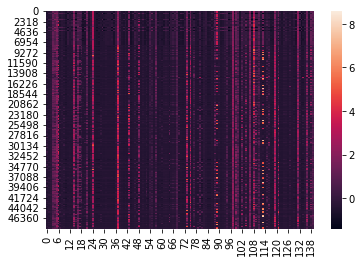

In [21]:
import seaborn as sns
sns.heatmap(test_pred)

In [22]:
def submit(test_pred,multi_path):
    submission = pd.read_csv(multi_path,index_col = 0)
    submission = submission["target"]
    print("data loaded")
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
    assert not submission.isna().any()
    # submission = submission.round(6) # reduce the size of the csv
    print("start -> submission.zip")
    submission.to_csv('submission.zip')
    print("submission.zip saved!")

In [23]:
%%time
submit(test_pred,multi_path = r"D:\python_project\MSCI\model_ensemble\submission_best.zip")

data loaded
start -> submission.zip
submission.zip saved!
CPU times: total: 1min 43s
Wall time: 3min 18s
